#### ADR Equation

In this I solve the ADR equation and sample it both numerically and analytically
I then check both these solutions in 2 different ML algorithms

- 1. Algorithm that fits N different lasso models and takes the average of each coefficient
- 2. algorithm that ravels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
% matplotlib inline
import pandas as pd

In [2]:
from functions import *

In [3]:
def plotter(main):
    import seaborn as sns
    check_len = main.shape[0]
    aa = np.arange(1,check_len,check_len/5)
    plt.figure()
    for i in range(len(aa)):
        plt.plot(main[aa[i],:],label='time = %s'%str(aa[i]))
    plt.xlabel('Position')
    plt.legend()
#     plt.grid(False)
    ax = plt.gca()
#     ax.set_facecolor('white')
def partials(main,dx,dt):
    Ut = []
    if isinstance(dt,list) == True:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt[i])
    else:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt)
        
    Ux = []
    for i in range(1,main.shape[1]-1):
        Ux.append((main[:,i+1]-main[:,i-1])/(2*dx))

    Ux2 = []
    for i in range(1,main.shape[1]-1):
        Ux2.append((main[:,i+1]+main[:,i-1] -2*main[:,i])/dx**2)

    Ux2 = np.array(Ux2).T
    Ut = np.array(Ut)
    Ux = np.array(Ux).T
    U2 = main**2

    Ut = Ut[1:,1:-1]
    Ux2 = Ux2[1:-1,:]
    Ux = Ux[1:-1,:]
    U2 = U2[1:-1,1:-1]
    U = main[1:-1,1:-1]
    UU2 = np.multiply(U,U2)
    UUx = np.multiply(U,Ux)
    return(Ut,U,U2,Ux,Ux2,UU2,UUx)
def find_fit(main,dx,dt):
    lasso = LassoCV(fit_intercept = True)
    betavals = []
    Ut,U,U2,Ux,Ux2,UU2,UUx = partials(main,dx,dt)
    for i in range(U.shape[1]):
        xtrain = np.c_[U[:,i],U2[:,i],Ux[:,i],Ux2[:,i],UU2[:,i],UUx[:,i]]
#         xtrain = np.c_[Ux[:,i],Ux2[:,i]]
        ytrain = Ut[:,i]
        lasso.fit(xtrain,ytrain)
        betavals.append(lasso.coef_)
    bmean = np.mean(betavals,axis=0)
    bstd = np.std(betavals,axis=0)
#     print(bmean)
    return(bmean)
    
def find_fit_qm(main,dx,dt):
    lasso = LassoCV(fit_intercept = False)
    betavals = []
    Ut,U,U2,Ux,Ux2,UU2,UUx = partials(main,dx,dt)
    for i in range(U.shape[1]):
        xtrain = np.c_[U[:,i],U2[:,i],Ux[:,i],Ux2[:,i],UU2[:,i],UUx[:,i]]
        
        ytrain = complex(0,1)*Ut[:,i]
        lasso.fit(xtrain,ytrain)
        betavals.append(lasso.coef_)
    bmean = np.mean(betavals,axis=0)
    bstd = np.std(betavals,axis=0)
#     print(bmean)
    return(bmean)

In [4]:
def actual_ad(nx,nsteps,dx,dt,vel,dif,cha,chb):
    x = np.zeros(nx)
    sizex = 1.
# declare arrays
    sizex = 1.0
    t = np.arange(8*dx**2,5,dt)
    x = np.arange(0,1.01,dx)
    f = np.zeros((nsteps,nx))
    
    for i in range(nsteps):
        for j in range(nx):
            f[i,j] = (1.0/np.sqrt(4*np.pi*dif*t[i]))*np.exp(-((x[j]-0.5+vel*t[0]-vel*t[i])**2)/(4*dif*t[i])) 
    return f


In [5]:
main,dx,dt = adr(20,15,.5,.5,0,0)
f = actual_ad(20,15,dx,dt,.5,.5,0,0)

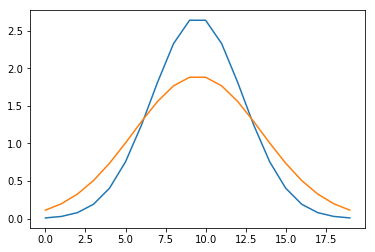

In [6]:
plt.plot(f[0,:])
plt.plot(main[0,1:-1])

### Algorithm 1: Multiple linear regression
- Notes:
    1.  Ut,U,U2,Ux,Ux2,UU2,UUx are the partials used
    2.  explore ADR eqn with method
    3.  try EDA

****

## Advection Diffusion Eqn

In [71]:
# quick test run before range of initial conditions

##### Numerical Scheme

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


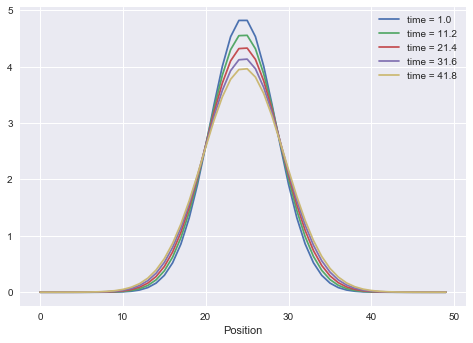

In [26]:
# small diffusion and velocity
main,dx,dt= adr(50,50,0.5,0.5,0,0)
plotter(main[:,1:-1])

#### Actual Solution

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


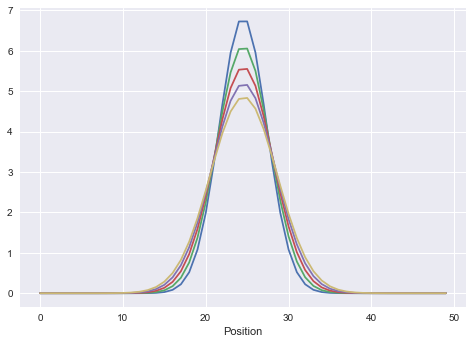

In [18]:
# check this - it only works with particular parameters
f = actual_ad(50,50,dx,dt,.5,.5,0,0)
plotter(f)

In [19]:
# old scheme fit
a =find_fit(main[:,1:-1],dx,dt)
b = find_fit(f,dx,dt)
tempdf = pd.DataFrame(np.c_[a,b],columns=['numerical','analytic'])

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [20]:
tempdf.index = [ 'U','U2','Ux','Uxx','UU2','UUx']

In [21]:
tempdf['expected'] = [0,0,0.5,0.5,0,0]

In [22]:
tempdf

,numerical,analytic,expected
U,0.000000,0.000000,0.0
U2,0.000000,0.000000,0.0
Ux,-0.026874,0.000000,0.5
Uxx,0.499194,0.495838,0.5
UU2,-0.002466,0.000000,0.0
UUx,-0.005082,-0.024701,0.0


In [73]:
vels

[0, 2, 4, 6, 8]

In [11]:
# store contains different vels and diff constants for fixed nx and nsteps
vels = [i*2 for i in range(1,5)]
diffs = [i*2 for i in range(1,5)]
store = {}
ctr = 0
for i in (vels):
    for j in (diffs):
        # keep nsteps fixed
        main,dx,dt= adr(50,50,i,j,0,0)
        f = actual_ad(50,50,dx,dt,i,j,0,0)
        a =find_fit(main[:,1:-1],dx,dt)
        b = find_fit(f,dx,dt)
        tempdf = pd.DataFrame(np.c_[a,b],columns=['numerical','analytic'])
        tempdf.index = [ 'U','U2','Ux','Ux2','UU2','UUx']
        tempdf['expected'] = [0,0,i,j,0,0]
        store[ctr] =tempdf
        ctr+=1

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. 

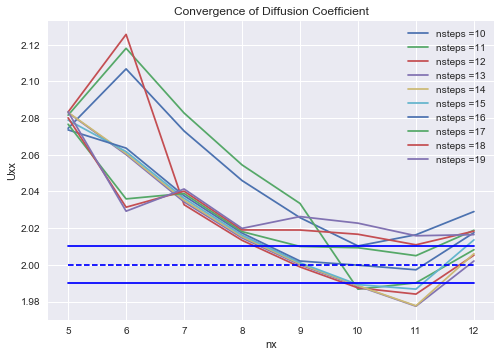

In [13]:
#### vary nx and nsteps and plot
# only worth looking at the third beta
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(10,20):
    grid_vals = []
    for nx in range(5,13):
        main,dx,dt= adr(nx,nsteps,2,2,0,0)
        grid_vals.append(find_fit(main,dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(5,13,1)
#     plt.plot(xvals,grid_vals[:,2],label = 'nsteps' + str(nsteps))
    plt.plot(xvals,grid_vals[:,3],label ='nsteps =%s'%str(nsteps))
plt.xlabel('nx')
plt.ylabel('Uxx')
plt.title('Convergence of Diffusion Coefficient')
plt.legend()
plt.plot(xvals,2*np.ones(len(xvals)),c='b',linestyle='--')
plt.plot(xvals,(2+0.01)*np.ones(len(xvals)),c='b')
plt.plot(xvals,(2-0.01)*np.ones(len(xvals)),c='b')

### ADR 
1 example of poor performance
leads us to ask whether there's a better solution

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


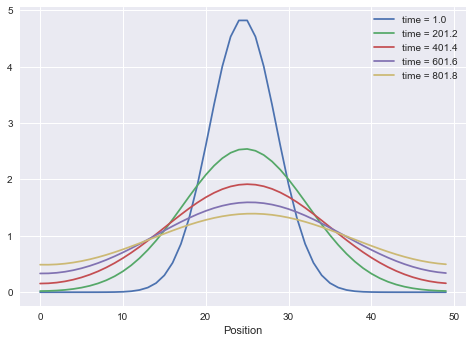

In [30]:
# small diffusion and velocity
main,dx,dt= adr(50,1000,1,1.5,1,2)
plotter(main[:,1:-1])

In [31]:
find_fit(main,dx,dt)

array([ 0.        ,  0.        , -0.126692  ,  1.52592294,  0.        ,
       -0.11294132])

#### Burgers
1 example of poor performance + can we do better?

In [4]:
main,dx,dt= burgers(100,100)
find_fit(main,dx,dt)

3.17586911195e-07


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. 

array([ 0.04117965, -0.00624878, -0.09148699,  0.03025089, -0.00587104,
       -0.03754957])

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


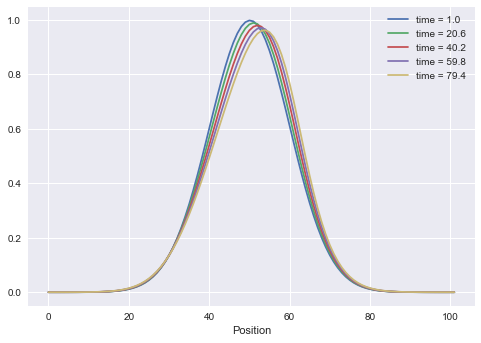

In [5]:
plotter(main[1:-1])

In [4]:
# main,dx,dt = qm(100,100,1,1)
# main = np.array(main)
# feval = main[:,0,:] + complex(0,1)*main[:,1,:]
# find_fit_qm(feval[1:1000,:],dx,dt)

****


### Algorithm 2: ravel
repeat AD
repeat ADR
repeat Burgers

w.r.t different nx,nsteps,dif,adv values (lots of parameters to play with)

add 3rd and 4th order terms and talk about the effect

In [6]:
def partials_new(main,dx,dt):
    Ut = []
    if isinstance(dt,list) == True:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt[i])
    else:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt)
        
    Ux = []
    for i in range(1,main.shape[1]-1):
        Ux.append((main[:,i+1]-main[:,i-1])/(2*dx))

    Ux2 = []
    for i in range(1,main.shape[1]-1):
        Ux2.append((main[:,i+1]+main[:,i-1] -2*main[:,i])/dx**2)

    Ux2 = np.array(Ux2).T
    Ut = np.array(Ut)
    Ux = np.array(Ux).T
    U2 = main**2

    Ut = Ut[1:,1:-1]
    Ux2 = Ux2[1:-1,:]
    Ux = Ux[1:-1,:]
    U2 = U2[1:-1,1:-1]
    U = main[1:-1,1:-1]
    UU2 = np.multiply(U,U2)
    UUx = np.multiply(U,Ux)
    return(Ut.ravel(),U.ravel(),U2.ravel(),Ux.ravel(),Ux2.ravel(),UU2.ravel(),UUx.ravel())


In [7]:
method =0
def find_fit_new(main,dx,dt):
    lasso = LassoCV(fit_intercept = False)
    RF = DecisionTreeRegressor()
    betavals = []
    Ut,U,U2,Ux,Ux2,UU2,UUx = partials_new(main,dx,dt)
    xtrain = np.c_[U,U2,Ux,Ux2,UU2,UUx]    
    ytrain = Ut
    if method == 0:
        lasso.fit(xtrain,ytrain)
        betavals.append(lasso.coef_)
 
    elif method == 1:
        RF.fit(xtrain,ytrain)
        betavals.append(RF.feature_importances_)
    return betavals
#     print(betavals)

In [47]:
# store contains different vels and diff for fixed nx and nsteps
vels = [i*2 for i in range(1,5)]
diffs = [i for i in range(1,5)]
store = {}
ctr = 0
for i in (vels):
    for j in (diffs):
        # keep nsteps fixed
        main,dx,dt= adr(50,50,i,j,0,0)
        f = actual_ad(50,50,dx,dt,i,j,0,0)
        a =find_fit_new(main[:,1:-1],dx,dt)
        b = find_fit_new(f,dx,dt)       
        tempdf = pd.DataFrame(np.c_[a[0],b[0]],columns=['numerical','analytic'])
        tempdf.index = [ 'U','U2','Ux','Uxx','UU2','UUx']
        tempdf['expected'] = [0,0,i,j,0,0]
        store[ctr] =tempdf
        ctr+=1

In [59]:
store[7]

,numerical,analytic,expected
U,-0.000000,-0.000000,0
U2,-0.000000,-0.000000,0
Ux,-1.238900,-3.549935,4
Uxx,3.995993,4.000994,4
UU2,-0.000000,-0.000000,0
UUx,-0.866743,-0.192171,0


In [23]:
m,dx,dt = adr(4,4,10,1,0,0)
print(find_fit_new(m,dx,dt))

[array([ 0.02961748,  0.        , -9.70180945,  1.06878061,  0.        , -0.        ])]


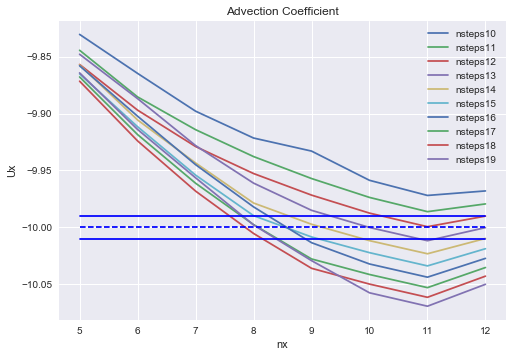

In [39]:
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(10,20):
    grid_vals = []
    for nx in range(5,13):
        main,dx,dt= adr(nx,nsteps,10,1,0,0)
        grid_vals.append(find_fit_new(main,dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(5,13,1)
    plt.plot(xvals,grid_vals[:,0,2],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel('Ux')
plt.legend()
plt.plot(xvals,-10*np.ones(len(xvals)),c='b',linestyle='--')
plt.plot(xvals,(-10+0.01)*np.ones(len(xvals)),c='b')
plt.plot(xvals,(-10-0.01)*np.ones(len(xvals)),c='b')
plt.title('Advection Coefficient')

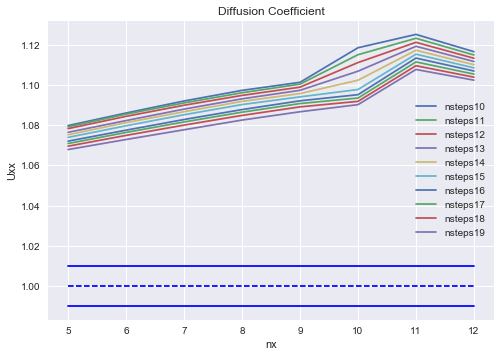

In [40]:
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(10,20):
    grid_vals = []
    for nx in range(5,13):
        main,dx,dt= adr(nx,nsteps,10,1,0,0)
        grid_vals.append(find_fit_new(main,dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(5,13,1)
    plt.plot(xvals,grid_vals[:,0,3],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel('Uxx')
plt.legend()
plt.plot(xvals,1*np.ones(len(xvals)),c='b',linestyle='--')
plt.plot(xvals,(1+0.01)*np.ones(len(xvals)),c='b')
plt.plot(xvals,(1-0.01)*np.ones(len(xvals)),c='b')
plt.title('Diffusion Coefficient')

In [ ]:
xaxis = [i for i in range(4,20)]

plt.plot(xaxis,grid_vals)

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


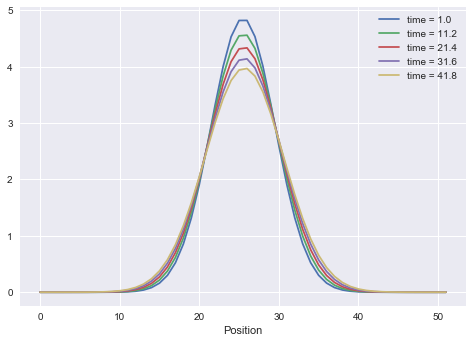

In [60]:
plotter(main)

### ADR Equation

In [94]:
# store contains different vels and diff for fixed nx and nsteps
vels = [i*2 for i in range(1,5)]
diffs = [i for i in range(1,5)]
store = {}
ctr = 0
for i in (vels):
    for j in (diffs):
        # keep nsteps fixed
        main,dx,dt= adr(20,10,i,j,5,5)
#         f = actual_ad(5,5,dx,dt,i,j,5,1)
        a =find_fit_new(main[:,1:-1],dx,dt)
#         b = find_fit_new(f,dx,dt)       
        tempdf = pd.DataFrame(np.c_[a[0]],columns=['numerical'])
        tempdf.index = [ 'U','U2','Ux','Uxx','UU2','UUx']
        tempdf['expected'] = [5,1,i,j,0,0]
        store[ctr] =tempdf
        ctr+=1

In [95]:
store[0]

,numerical,expected
U,-0.000000,5
U2,-0.000000,1
Ux,-1.962930,2
Uxx,1.088762,1
UU2,-0.598707,0
UUx,-0.000000,0


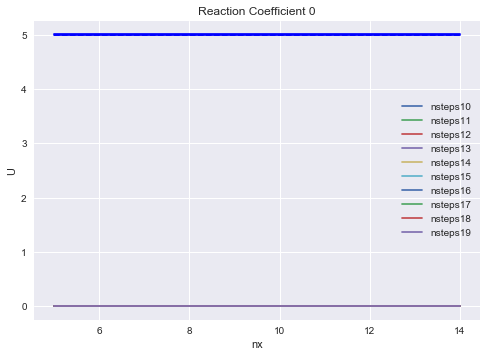

In [104]:
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(10,20):
    grid_vals = []
    for nx in range(5,15):
        main,dx,dt= adr(nx,nsteps,2,1,5,1)
        grid_vals.append(find_fit_new(main,dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(5,15,1)
    plt.plot(xvals,grid_vals[:,0,1],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel('U')
plt.legend()
plt.plot(xvals,5*np.ones(len(xvals)),c='b',linestyle='--')
plt.plot(xvals,(5+0.01)*np.ones(len(xvals)),c='b')
plt.plot(xvals,(5-0.01)*np.ones(len(xvals)),c='b')
plt.title('Reaction Coefficient 0')

### Burgers

In [8]:
main,dx,dt= burgers(50,10)
find_fit_new(main,dx,dt)

5.73866807597e-07


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[array([ 0.02936796, -0.05416394, -0.01629735,  0.7072511 ,  0.01248449,
        -0.96759316])]

0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003

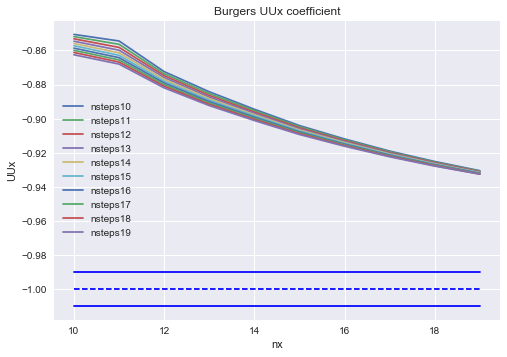

In [12]:
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(10,20):
    grid_vals = []
    for nx in range(10,20):
        main,dx,dt= burgers(nx,nsteps)
        grid_vals.append(find_fit_new(main,dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(10,20,1)
    plt.plot(xvals,grid_vals[:,0,5],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel('UUx')
plt.legend()
plt.plot(xvals,-1*np.ones(len(xvals)),c='b',linestyle='--')
plt.plot(xvals,(-1+0.01)*np.ones(len(xvals)),c='b')
plt.plot(xvals,(-1-0.01)*np.ones(len(xvals)),c='b')
plt.title('Burgers UUx coefficient')

In [14]:
grid_vals[-1,0,:]

array([  2.78541250e-04,  -1.43737098e-03,  -3.12742249e-02,
         9.95103430e-01,  -6.13687833e-05,  -9.32522422e-01])

0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003077e-05
9.72192724076e-06
7.58504440392e-06
6.07637100989e-06
4.97975626184e-06
0.000103788114192
6.05470427951e-05
3.79089458241e-05
2.51973309401e-05
1.76151356434e-05
1.28515003

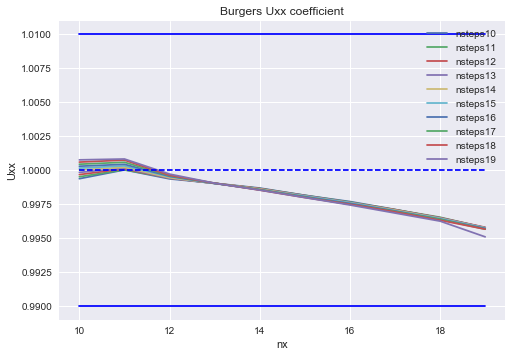

In [13]:
b

In [125]:
grid_vals[-1,0,:]

array([  2.35489349e-03,  -3.88334366e-03,  -4.49920803e-03,
         0.00000000e+00,   4.26014022e-04,  -9.90722475e-01])

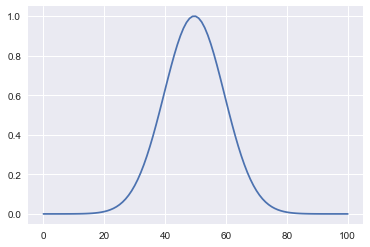

In [123]:
plt.plot(main[0,:])

In [106]:
def partials_new(main,dx,dt):
    Ut = []
    if isinstance(dt,list) == True:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt[i])
    else:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt)
        
    Ux = []
    for i in range(1,main.shape[1]-1):
        Ux.append((main[:,i+1]-main[:,i-1])/(2*dx))

    Uxx = []
    for i in range(1,main.shape[1]-1):
        Uxx.append((main[:,i+1]+main[:,i-1] -2*main[:,i])/dx**2)

    Uxxx = []
    for i in range(1,main.shape[1]-2):
        Uxxx.append((main[:,i+2]-3*main[:,i+1]+3*main[:,i]-main[:,i-1])/dx**3)

    Uxx = np.array(Uxx).T
    Uxxx = np.array(Uxxx).T
    Ut = np.array(Ut)
    Ux = np.array(Ux).T
    U2 = main**2

    Ut = Ut[1:,1:-2]
    Uxxx = Uxxx[1:-1,:]
    Uxx = Uxx[1:-1,:-1]
    Ux = Ux[1:-1,:-1]
    U2 = U2[1:-1,1:-2]
    U = main[1:-1,1:-2]
    UU2 = np.multiply(U,U2)
    UUx = np.multiply(U,Ux)
    return(Ut.ravel(),U.ravel(),U2.ravel(),Ux.ravel(),Uxx.ravel(),Uxxx.ravel(),UU2.ravel(),UUx.ravel())


In [107]:
method =0
def find_fit_new(main,dx,dt):
    lasso = LassoCV(fit_intercept = False)
    RF = DecisionTreeRegressor()
    betavals = []
    Ut,U,U2,Ux,Ux2,Uxxx,UU2,UUx = partials_new(main,dx,dt)
    xtrain = np.c_[U,U2,Ux,Ux2,Uxxx,UU2,UUx]    
    ytrain = Ut
    if method == 0:
        lasso.fit(xtrain,ytrain)
        betavals.append(lasso.coef_)
 
    elif method == 1:
        RF.fit(xtrain,ytrain)
        betavals.append(RF.feature_importances_)
    return betavals
#     print(betavals)

0.0103897064212
0.00979792884289
0.00542475310432
0.00220683013324


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0103897064212
0.00979792884289
0.00542475310432
0.00220683013324
0.0103897064212


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.00979792884289
0.00542475310432
0.00220683013324
0.0103897064212
0.00979792884289


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.00542475310432
0.00220683013324
0.0103897064212
0.00979792884289
0.00542475310432


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. 

0.00220683013324
0.0103897064212
0.00979792884289
0.00542475310432
0.00220683013324


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0103897064212
0.00979792884289
0.00542475310432
0.00220683013324


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0103897064212
0.00979792884289
0.00542475310432
0.00220683013324


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0103897064212
0.00979792884289
0.00542475310432
0.00220683013324


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0103897064212
0.00979792884289
0.00542475310432
0.00220683013324


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


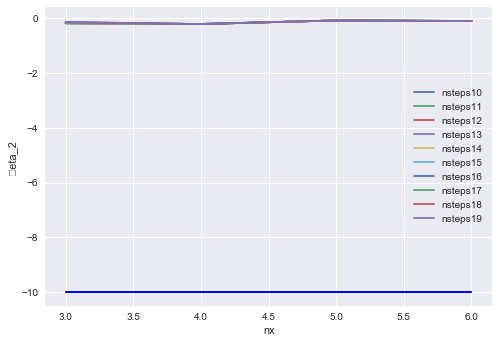

In [108]:
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(10,20):
    grid_vals = []
    for nx in range(3,7):
        main,dx,dt= burgers(nx,nsteps)
        grid_vals.append(find_fit_new(main,dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(3,7,1)
    plt.plot(xvals,grid_vals[:,0,2],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel(u'\beta_2')
plt.legend()
plt.plot(xvals,-10*np.ones(len(xvals)),c='b',linestyle='--')
plt.plot(xvals,(-10+0.01)*np.ones(len(xvals)),c='b')
plt.plot(xvals,(-10-0.01)*np.ones(len(xvals)),c='b')

In [17]:
main,dx,dt= adr(5,30,10,1,1,0)
find_fit_new(main,dx,dt)

[array([  1.04691893e+00,  -0.00000000e+00,  -9.98402921e+00,
          1.11433167e+00,   5.94958519e-03,  -0.00000000e+00,
         -0.00000000e+00])]

In [7]:
# [U[:,i],U2[:,i],Ux[:,i],Ux2[:,i],UU2[:,i],UUx[:,i]]
#         xtrain = np.c_[Ux[:,i],Ux2[:,i]]
main,dx,dt= adr(5,30,10,1,1,5)
find_fit_new(main,dx,dt)

[array([-0.81543959, -0.        , -9.81085955,  1.12352328, -0.        , -0.        ])]

###

Look at KS````````

In [5]:
def sech(x):
    return np.cosh(x)**(-1)
# define constants analytic
c = 1.
x0 = 0.5

In [6]:
x = np.linspace(0,300,1000)
t = np.linspace(0,10,100)

In [7]:
def ks(x,x0,c,t):
    return (c/2)*(sech(np.sqrt(c)/2*(x-c*t-x0)))**2

In [8]:
main= np.zeros((len(t),len(x)))
for i in range(len(t)):
    for j in range(len(x)):
        main[i,j] = (ks(x[j],x0,c,t[i])+ks(x[j],x0+100,c/2,t[i]))

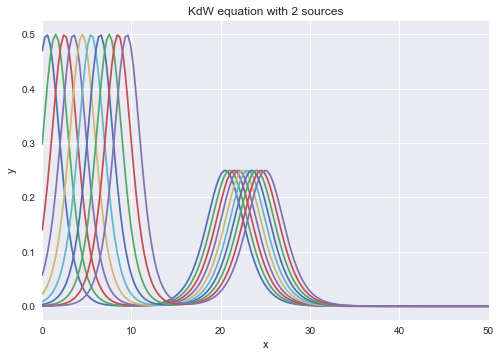

In [11]:
import seaborn as sns
plt.figure()
for i in range(10):
    plt.plot(x,ks(x,x0,c,i) + ks(x,x0+20,c/2,i))
plt.xlim([0,50])  
plt.title('KdW equation with 2 sources')
plt.xlabel('x')
plt.ylabel('y')

In [21]:
def partials_new(main,dx,dt):
    Ut = []
    if isinstance(dt,list) == True:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt[i])
    else:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt)
        
    Ux = []
    for i in range(1,main.shape[1]-1):
        Ux.append((main[:,i+1]-main[:,i-1])/(2*dx))

    Uxx = []
    for i in range(1,main.shape[1]-1):
        Uxx.append((main[:,i+1]+main[:,i-1] -2*main[:,i])/dx**2)

    Uxxx = []
    for i in range(1,main.shape[1]-2):
        Uxxx.append((main[:,i+2]-3*main[:,i+1]+3*main[:,i]-main[:,i-1])/dx**3)

    Uxx = np.array(Uxx).T
    Uxxx = np.array(Uxxx).T
    Ut = np.array(Ut)
    Ux = np.array(Ux).T
    U2 = main**2

    Ut = Ut[1:,1:-2]
    Uxxx = Uxxx[1:-1,:]
    Uxx = Uxx[1:-1,:-1]
    Ux = Ux[1:-1,:-1]
    U2 = U2[1:-1,1:-2]
    U = main[1:-1,1:-2]
    UU2 = np.multiply(U,U2)
    UUx = np.multiply(U,Ux)
    return(Ut.ravel(),U.ravel(),U2.ravel(),Ux.ravel(),Uxx.ravel(),Uxxx.ravel(),UU2.ravel(),UUx.ravel())


In [22]:
method =0
def find_fit_new(main,dx,dt):
    lasso = LassoCV(fit_intercept = False)
#     RF = DecisionTreeRegressor()
    betavals = []
    Ut,U,U2,Ux,Ux2,Uxxx, UU2,UUx = partials_new(main,dx,dt)
    xtrain = np.c_[U,U2,Ux,Ux2,Uxxx,UU2,UUx]    
    ytrain = Ut
    if method == 0:
        lasso.fit(xtrain,ytrain)
        betavals.append(lasso.coef_)
 
    elif method == 1:
        RF.fit(xtrain,ytrain)
        betavals.append(RF.feature_importances_)
    return betavals
#     print(betavals)

In [14]:
# 3exact soln fit
dx = 0.3
dt = 0.1

find_fit_new(main,dx,dt)

[array([  1.96551546e-03,  -1.10279663e-01,  -3.71663403e-01,
         -7.59637265e-02,  -5.65825655e-01,   1.84478645e-01,
         -3.55023724e+00])]

### Analytic

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. 

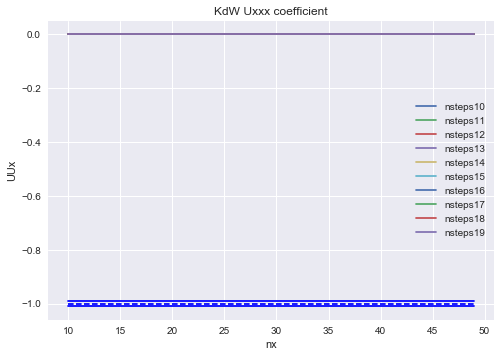

In [17]:
# tool for plotting
# U,U2,Ux,Ux2,Uxxx,UU2,UUx
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(10,20):
    grid_vals = []
    for nx in range(10,50):
        x = np.linspace(0,300,nx)
        t = np.linspace(0,10,nsteps)
        dx = 300./nx
        dt = 10./nsteps
        main= np.zeros((len(t),len(x)))
        for i in range(len(t)):
            for j in range(len(x)):
                main[i,j] = (ks(x[j],x0,c,t[i]))
        grid_vals.append(find_fit_new(main,dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(10,50,1)
    plt.plot(xvals,grid_vals[:,0,6],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel('UUx')
plt.legend()
plt.plot(xvals,-1*np.ones(len(xvals)),c='b',linestyle='--')
plt.plot(xvals,(-1+0.01)*np.ones(len(xvals)),c='b')
plt.plot(xvals,(-1-0.01)*np.ones(len(xvals)),c='b')
plt.title('KdW Uxxx coefficient')

In [55]:
grid_vals[0]

array([[ 0.        , -0.        , -1.05443305,  0.29494651,  0.00690685,
        -0.        , -0.        ]])

In [46]:
### Numerical KdV

def numerical_kdv(nx,nsteps):
    x = np.zeros(nx)
    f = np.zeros(nx+2)
    fnew = np.zeros(nx+2)
    main = []
    tt = []
    x0 = 25
    # baseline parameters
    sizex = 50.0
    dx = sizex/float(nx-1)
    vel = 100.
    cfl = .01
    dtd = 1.0
    dta = 1.0
#     if vel != 0:
    dta = dx**2/vel
    dtc = 1.0

    dt = cfl*min(min(dta,dtd),dtc)
#     dt = 0.1
    # initial conditions
    for i in range(nx):
        x[i] = dx*float(i)
        f[i] = ks(x[i],x0,vel,0) 
#         + ks(x[i],x0+25,vel/2,0)
    main.append(np.copy(f))
    
    for j in range(nsteps):
        # no bc
        f[0] = f[nx-5]
        f[nx-4] = f[1]
        for k in range(1,nx-3):
            fnew[k] = f[k] -dt*( f[k+2]/(dx**3) -f[k-1]/(dx**3) + (f[k]*vel/dx - 3./dx**3)*f[k+1] + (-f[k]*vel/dx + 3./dx**3)*f[k]) 
#             fnew[k] = f[k] - (dt/dx)*(f[k]-f[k-1]) - (dt/dx**3)*(f[k]-3*f[k-1]+3*f[k-2]-f[k-3])
        for k in range(1,nx-3):
            f[k] = fnew[k]
        main.append(np.copy(fnew))
        
    main = np.array(main)
    return(main,dx,dt)

       

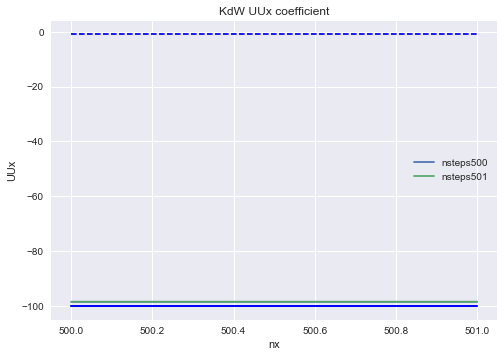

In [47]:
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(500,502):
    grid_vals = []
    for nx in range(4000,4002):
        main,dx,dt = numerical_kdv(nx,nsteps)
        grid_vals.append(find_fit_new(main,dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(500,502,1)
    plt.plot(xvals,grid_vals[:,0,6],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel('UUx')
plt.legend()
plt.plot(xvals,-1*np.ones(len(xvals)),c='b',linestyle='--')
plt.plot(xvals,(-100+0.01)*np.ones(len(xvals)),c='b')
plt.plot(xvals,(-100-0.01)*np.ones(len(xvals)),c='b')
plt.title('KdW UUx coefficient')

In [48]:
grid_vals[:,0,:]

array([[ -0.        ,  -0.        ,  -0.        ,  -3.83140996,
         -0.46870999,   0.44032481, -98.40027916],
       [ -0.        ,  -0.        ,  -0.        ,  -3.82648948,
         -0.4684221 ,   0.44027222, -98.39921534]])

### Quantum Mechanics

In [4]:
# Function definitions
def qm(nx,nt,dif,omh):
    lop  = 1
    Aold = np.zeros(nx)
    A = np.zeros(nx)
    Anew = np.zeros(nx)
    Bold = np.zeros(nx)
    B = np.zeros(nx)
    Bnew = np.zeros(nx)
    x = np.zeros(nx)
    pot = np.zeros(nx)
    qpot = np.zeros(nx)
    hc = np.zeros(nx)
    hw = np.zeros(nx)
    he = np.zeros(nx)
    jw= np.zeros(nx)
    je = np.zeros(nx)
    rho = np.zeros(nx)
    lop = lop
    main = []
    energy = []

    nout = 100

    dif =dif
    omh =omh
    hlen = np.sqrt(0.5*dif/omh)
    hvel = np.sqrt(0.5*dif*omh)

    sigma = hlen
    vel = hvel

    htim = 2*np.pi/omh
    sizex = 20*hlen

    sizet = 200*htim
    dx = sizex/float(nx-1)
    dt = 0.01/omh

#     nt = sizet/dt

    if lop == 0:
        vamp = 0
    else:
        vamp = 1

    dtd = 1
    if dif != 0:
        dtd = 0.5*dx*dx/dif
    dta = 1
    if vel != 0:
        dta = dx/abs(vel)

    cfl = 0.5
    dt = cfl*min(dta,dtd)

    delta = dif*dt/(dx**2)
    alfa = vel*dt/dx
    omega = vamp*dt

    if(alfa > 1.0):
        print('dt too large, alfa')
    if(delta>1.0):
        print('dt too large, delta')
    if(omega>1.0):
        print('dt too large, omega')


    #potmax = 0.5*omh*omh*(0.25*sizex*sizex)
    if(lop>1):
        potmax=vamp

    j0 = (nx-1)/2
    for j in range(nx):
        x[j]= -0.5*sizex+dx*(float(j))
        xj   = x[j]
        rho[j]  = np.exp(-0.25*xj*xj/sigma/sigma)
        Aold[j] = rho[j]*np.cos(vel*xj)
        Bold[j] = rho[j]*np.sin(vel*xj)
        rhoA    = Aold[j]*Aold[j]
        rhoB    = Bold[j]*Bold[j]
        if(lop == 1):           
            pot[j] = vamp*0.5*omh*omh*xj*xj
        elif lop == 0:
            pot[j] = 0.0
        elif lop == 2:
            pot[j]=0.0                         
            j1 = 2
            j2 = j1 + 0.5
            if(x[j]>j1) and (x[j]<j2):
                pot[j]=vamp


    for j in range(nx):
        je[j] = int(j+1)
        if (je[j]>nx-1):
            je[j]= int(0)
        jw[j] = int(j-1)
        if(jw[j]<0):
            jw[j]= int(nx-1)
        omega = pot[j]*dt
        hc[j] =  delta+omega
        hw[j] = -delta/2.
        he[j] = -delta/2.

        hB    = hc[j]*Bold[j]+hw[j]*Bold[int(jw[j])]+he[j]*Bold[int(je[j])]
        A[j]  = Aold[j]+hB
        hA    = hc[j]*Aold[j]+hw[j]*Aold[int(jw[j])]+he[j]*Aold[int(je[j])]
        B[j]  = Bold[j]-hA

    
    for it in range(2,int(nt)):
        for j in range(nx): 
            hB = hc[j]*B[j]+hw[j]*B[int(jw[j])]+he[j]*B[int(je[j])]
            Anew[j] = Aold[j]+2.0*hB

        for j in range(nx):
            hA = hc[j]*A[j]+hw[j]*A[int(jw[j])]+he[j]*A[int(je[j])]
            Bnew[j] = Bold[j]-2.0*hA


        # c prepare new timestep
        for j in range(nx):
            Aold[j] = A[j] 
            Bold[j] = B[j] 
            A[j] = Anew[j]
            B[j]    = Bnew[j] 

            rho[j] = (A[j]*A[j]+B[j]*B[j])
        main.append((np.copy(A),np.copy(B),np.copy(rho)))
        # diagnostic
    return main,dx,dt,sizex


In [5]:
method =0
def find_fit_new(main,main2,dx,dt):
    lasso = LassoCV(fit_intercept = False)
#     RF = DecisionTreeRegressor()
    betavals = []
    Ut,U,U2,Ux,Ux2,Uxxx, UU2,UUx,x2u = partials_new(main,main2,dx,dt)
    xtrain = np.c_[U,U2,Ux,Ux2,Uxxx,UU2,UUx,x2u]    
    ytrain = Ut
    if method == 0:
        lasso.fit(xtrain,ytrain)
        betavals.append(lasso.coef_)
 
    elif method == 1:
        RF.fit(xtrain,ytrain)
        betavals.append(RF.feature_importances_)
    return betavals
#     print(betavals)

In [6]:
main,dx,dt,sizex = qm(100,80,1.,1.)
main = np.array(main)

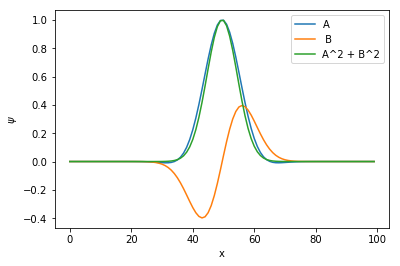

In [7]:
plt.plot(main[0,0,:],label = 'A')
plt.plot(main[0,1,:],label =' B')
plt.plot(main[0,2,:],label = 'A^2 + B^2')
plt.xlabel('x')
plt.ylabel(u'$\psi$')
plt.legend()

IndexError: index 100 is out of bounds for axis 0 with size 78

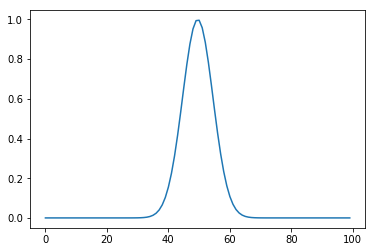

In [8]:
plt.plot(main[0,2,:],label = 'rho dt = 0')
plt.plot(main[100,2,:],label = 'rho dt = 100')
plt.plot(main[200,2,:],label = 'rho dt = 200')
plt.plot(main[300,2,:],label = 'rho dt = 300')
plt.xlabel('x')
plt.ylabel(u'$\psi$')
plt.legend()

In [9]:
xarr = []
for j in range(100):
    xarr.append(-0.5*sizex+dx*(float(j)))

In [9]:
def partials_new(main,main2,dx,dt):
    Ut = []
    if isinstance(dt,list) == True:
        for i in range(main2.shape[0]-1):
            Ut.append((main2[i+1,:]-main2[i,:])/dt[i])
    else:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt)
        
    Ux = []
    for i in range(1,main.shape[1]-1):
        Ux.append((main[:,i+1]-main[:,i-1])/(2*dx))

    Uxx = []
    for i in range(1,main.shape[1]-1):
        Uxx.append((main[:,i+1]+main[:,i-1] -2*main[:,i])/dx**2)

    Uxxx = []
    for i in range(1,main.shape[1]-2):
        Uxxx.append((main[:,i+2]-3*main[:,i+1]+3*main[:,i]-main[:,i-1])/dx**3)

    Uxx = np.array(Uxx).T
    Uxxx = np.array(Uxxx).T
    Ut = np.array(Ut)
    Ux = np.array(Ux).T
    U2 = main**2

    Ut = Ut[1:,1:-2]
    Uxxx = Uxxx[1:-1,:]
    Uxx = Uxx[1:-1,:-1]
    Ux = Ux[1:-1,:-1]
    U2 = U2[1:-1,1:-2]
    U = main[1:-1,1:-2]
    x2u = U*(np.array(xarr)[1:-2])**2
#     print(x2u.shape)
    UU2 = np.multiply(U,U2)
    UUx = np.multiply(U,Ux)
    return(Ut.ravel(),U.ravel(),U2.ravel(),Ux.ravel(),Uxx.ravel(),Uxxx.ravel(),UU2.ravel(),UUx.ravel(),x2u.ravel())


In [13]:
main.shape

(798, 3, 100)

In [10]:
# main = np.array(main)
# main.shape
psiA= main[0:450,0,:]
psiB= main[0:450,1,:]

print(find_fit_new(psiB,psiA,dx,dt))
# print(find_fit_new(psiB,dx,dt))

NameError: name 'xarr' is not defined

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. 

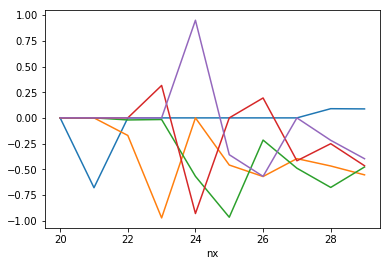

In [18]:
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(5,10):
    grid_vals = []
    for nx in range(10,20):
        main,dx,dt,sizex = qm(nx,nsteps,1.,1.)
        xarr = []
        for j in range(nx):
            xarr.append(-0.5*sizex+dx*(float(j)))
        main = np.array(main)
        grid_vals.append(find_fit_new(main[:,0,:],main[:,1,:],dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(20,30,1)
    plt.plot(xvals,grid_vals[:,0,7],label = 'nsteps' + str(nsteps))
#     plt.plot(xvals,grid_vals[:,0,3],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
# plt.ylabel('Uxx')
# plt.legend()
# plt.plot(xvals,1*np.ones(len(xvals)),c='b',linestyle='--')
# plt.plot(xvals,(1+0.01)*np.ones(len(xvals)),c='b')
# plt.plot(xvals,(1-0.01)*np.ones(len(xvals)),c='b')
# plt.title('Burgers Uxx coefficient')

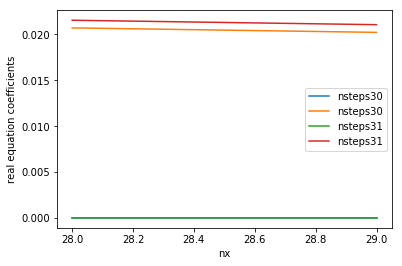

In [47]:
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(30,32):
    grid_vals = []
    for nx in range(100,102):
        main,dx,dt,sizex = qm(nx,nsteps,1.,1.)
        xarr = []
        for j in range(nx):
            xarr.append(-0.5*sizex+dx*(float(j)))
        main = np.array(main)
        grid_vals.append(find_fit_new(main[:,0,:],-main[:,1,:],dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(28,30,1)
    plt.plot(xvals,grid_vals[:,0,7],label = 'nsteps' + str(nsteps))
    plt.plot(xvals,grid_vals[:,0,3],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel('real equation coefficients')
plt.legend()


In [48]:
grid_vals


array([[[ 0.02735931,  0.        , -0.86356464,  0.02155233, -0.0093541 ,
          0.        , -0.        ,  0.        ]],

       [[ 0.02678978,  0.        , -0.86362503,  0.02106834, -0.00937598,
          0.        , -0.        ,  0.        ]]])

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. 

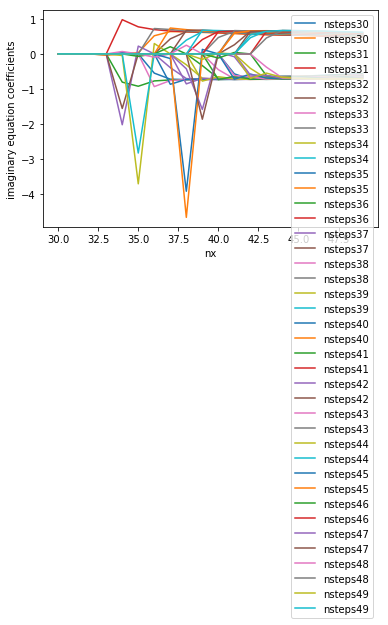

In [22]:
# tool for plotting
grid_vals = []
# nsteps fixed
plt.figure()
for nsteps in range(30,50):
    grid_vals = []
    for nx in range(30,50):
        main,dx,dt,sizex = qm(nx,nsteps,1.,1.)
        xarr = []
        for j in range(nx):
            xarr.append(-0.5*sizex+dx*(float(j)))
        main = np.array(main)
        grid_vals.append(find_fit_new(main[:,1,:],main[:,0,:],dx,dt))
    grid_vals = np.array(grid_vals)  
    xvals = np.arange(30,50,1)
    plt.plot(xvals,grid_vals[:,0,7],label = 'nsteps' + str(nsteps))
    plt.plot(xvals,grid_vals[:,0,3],label = 'nsteps' + str(nsteps))
plt.xlabel('nx')
plt.ylabel('imaginary equation coefficients')
plt.legend()


In [51]:
grid_vals

array([[[ 1.30607465, -0.25882508, -1.05871087,  0.53553095,  0.        ,
          0.        ,  0.        , -0.61625309]],

       [[ 1.27751093, -0.31128771, -1.04659634,  0.51991358,  0.0014063 ,
          0.        ,  0.        , -0.59609621]],

       [[ 1.24693103, -0.36727826, -1.03227729,  0.50546103,  0.00402758,
          0.        ,  0.        , -0.57620013]],

       [[ 1.2154313 , -0.42234563, -1.0180154 ,  0.491365  ,  0.00690192,
          0.        ,  0.        , -0.55692232]],

       [[ 1.18158085, -0.47729387, -1.00378339,  0.47714978,  0.00999261,
          0.        , -0.        , -0.53754097]],

       [[ 1.14409348, -0.53269054, -0.98955614,  0.46238573,  0.01327125,
          0.        , -0.        , -0.51742192]],

       [[ 1.10190494, -0.5888504 , -0.97532542,  0.44670738,  0.01671028,
          0.        , -0.        , -0.49604153]],

       [[ 1.053824  , -0.64613075, -0.96105808,  0.42972943,  0.0202967 ,
          0.        , -0.        , -0.47284814]],



In [13]:
def car():
    return c

In [16]:
c = 10
car()

10

In [17]:
c = 11
car()

11

# Algo using normalized vectors

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
def partials_new(main,dx,dt):
    Ut = []
    if isinstance(dt,list) == True:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt[i])
    else:
        for i in range(main.shape[0]-1):
            Ut.append((main[i+1,:]-main[i,:])/dt)
        
    Ux = []
    for i in range(1,main.shape[1]-1):
        Ux.append((main[:,i+1]-main[:,i-1])/(2*dx))

    Ux2 = []
    for i in range(1,main.shape[1]-1):
        Ux2.append((main[:,i+1]+main[:,i-1] -2*main[:,i])/dx**2)

    Ux2 = np.array(Ux2).T
    Ut = np.array(Ut)
    Ux = np.array(Ux).T
    U2 = main**2

#     Ut = scaler.fit_transform(Ut[1:,1:-1])
    Ux2 = scaler.fit_transform(Ux2[1:-1,:])
    Ux = scaler.fit_transform(Ux[1:-1,:])
    U2 = scaler.fit_transform(U2[1:-1,1:-1])
    U = scaler.fit_transform(main[1:-1,1:-1])
    UU2 = scaler.fit_transform(np.multiply(U,U2))
    UUx = scaler.fit_transform(np.multiply(U,Ux))
    Ut = Ut[1:,1:-1]
#     Ux2 = Ux2[1:-1,:]
#     Ux = Ux[1:-1,:]
#     U2 = U2[1:-1,1:-1]
#     U = main[1:-1,1:-1]
#     UU2 = np.multiply(U,U2)
#     UUx = np.multiply(U,Ux)

    
    return(Ut.ravel(),U.ravel(),U2.ravel(),Ux.ravel(),Ux2.ravel(),UU2.ravel(),UUx.ravel())


In [41]:
method =0
def find_fit_new(main,dx,dt):
    lasso = LassoCV(fit_intercept = False)
    RF = DecisionTreeRegressor()
    betavals = []
    Ut,U,U2,Ux,Ux2,UU2,UUx = partials_new(main,dx,dt)
    xtrain = np.c_[U,U2,Ux,Ux2,UU2,UUx]    
    ytrain = Ut
    if method == 0:
        lasso.fit(xtrain,ytrain)
        betavals.append(lasso.coef_)
 
    elif method == 1:
        RF.fit(xtrain,ytrain)
        betavals.append(RF.feature_importances_)
    return betavals
#     print(betavals)

In [44]:
# store contains different vels and diff for fixed nx and nsteps
vels = [i*2 for i in range(1,5)]
diffs = [i for i in range(1,5)]
store = {}
ctr = 0
for i in (vels):
    for j in (diffs):
        # keep nsteps fixed
        main,dx,dt= adr(50,50,i,j,0,0)
        f = actual_ad(50,50,dx,dt,i,j,0,0)
        a =find_fit_new(main[:,1:-1],dx,dt)
        b = find_fit_new(f,dx,dt)       
        tempdf = pd.DataFrame(np.c_[a[0],b[0]],columns=['numerical','analytic'])
        tempdf.index = [ 'U','U2','Ux','Uxx','UU2','UUx']
        tempdf['expected'] = [0,0,i,j,0,0]
        store[ctr] =tempdf
        ctr+=1

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Shaan Desai\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. 

In [46]:
store[7]

,numerical,analytic,expected
U,-0.000000e+00,-0.000000e+00,0
U2,-0.000000e+00,-0.000000e+00,0
Ux,-0.000000e+00,-2.319452e-15,4
Uxx,1.648390e-13,0.000000e+00,4
UU2,-0.000000e+00,-0.000000e+00,0
UUx,-0.000000e+00,-0.000000e+00,0
